# Pré requis

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive


In [ ]:
!pip install pycoingecko
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.2 MB/s 
     |████████████████████████████████| 2.8 MB 10.8 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
url="https://api.coingecko.com/api/v3/coins/terra-luna/market_chart"
res = requests.get(url,params={'id':'terra-luna','vs_currency' : 'USD','days' : '500'},verify=False)

NameError: ignored

In [ ]:
df=pd.concat([pd.DataFrame(res.json()['market_caps']),pd.DataFrame(res.json()['prices'])[1]],axis=1)

NameError: ignored

In [ ]:
df.columns=["time",'market_caps','prices']

In [ ]:
df['Date']=pd.to_datetime(df['time'],unit='ms').dt.strftime('%Y-%m-%d')

In [ ]:
df.drop(df.tail(1).index,inplace=True)


,time,market_caps,prices,Date
0,1607817600000,2.280507e+08,0.482484,2020-12-13
1,1607904000000,2.265155e+08,0.479591,2020-12-14
2,1607990400000,2.230007e+08,0.472124,2020-12-15
3,1608076800000,2.258683e+08,0.478174,2020-12-16
4,1608163200000,2.383639e+08,0.503731,2020-12-17
...,...,...,...,...
495,1650585600000,3.183709e+10,90.679727,2022-04-22
496,1650672000000,3.281328e+10,93.688100,2022-04-23
497,1650758400000,3.127944e+10,89.608794,2022-04-24
498,1650844800000,3.164018e+10,90.460928,2022-04-25


In [ ]:
datetime.today().year

2022

In [ ]:
(datetime.today()-datetime(datetime.today().year,1,1)).days

115

In [ ]:
datetime(2021,7,1)

datetime.datetime(2021, 7, 1, 0, 0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline 
from pycoingecko import CoinGeckoAPI
import math
import time
from datetime import date, timedelta, datetime
import requests
import json
from pypfopt.expected_returns import mean_historical_return, ema_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import sample_cov, semicovariance, exp_cov, CovarianceShrinkage, fix_nonpositive_semidefinite, cov_to_corr
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation
from dateutil.relativedelta import relativedelta

In [ ]:
#Function who gets the daily historical data from CRYPTOCOMPARE
def daily_price_historical(symbol, comparison_symbol, limit=1, aggregate=1, exchange='', allData='true'):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    if not df.empty:
      df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return df

# Get the Data 
## Get the top by marketcap

In [ ]:
cg = CoinGeckoAPI()
#Top 100 by marketcap
df=pd.DataFrame(cg.get_coins_markets(vs_currency='usd',price_change_percentage='7d,30d,1y',per_page=100))
df2 = df[["id","symbol","name",'current_price','market_cap','total_volume','price_change_percentage_24h','circulating_supply','total_supply','ath','ath_change_percentage','price_change_percentage_7d_in_currency','price_change_percentage_30d_in_currency','price_change_percentage_1y_in_currency']]
df2["symbol"]=df2["symbol"].str.upper()
df2.drop(df2[df2["market_cap"]<=1000000000 ].index,inplace=True)
df2.drop(df2[df2["circulating_supply"]==0 ].index,inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Get the historical 'close' from the symbol collected before

Get historical data : price + market cap with coingeckoAPI sur les 500 derniers jour, on vire les coin qui ne sont pas existants depuis ce laps de temps

In [ ]:
listeBanCoin=['tether','usd-coin','binance-usd','terrausd','dai','compound-usd-coin','shiba-inu','dogecoin','cdai','true-usd','staked-ether']
liste=list(df2["id"])
for i in listeBanCoin:
  if i in liste :
    liste.remove(i)
dico = {}
c=0
for i in liste:
  l=cg.get_coin_market_chart_by_id(i,vs_currency='USD',days=500)
  if c==48 :
    time.sleep(45)
  if len(l['prices'])==501 and l['market_caps'][0][1]!=0 :
    b=[]
    b.append([el[0] for el in l['prices']])
    b[0]=[datetime.fromtimestamp(d/1000) for d in b[0]]
    b.append([el[1] for el in l['prices']])
    b.append([el[1] for el in l['market_caps']])   
    dico[i]=b
  c=c+1

Get prices from the first year of the range of our data

In [ ]:
l=[]
name=[]
for i in dico :
  l.append(dico[i][1][:250])
  name.append(i)
df=pd.DataFrame(l).transpose()
df.columns=name

# Indice a partir des market cap circulante

## Indice BTC + ETH avec les market cap > 1 000 000 000$

In [ ]:
#Create the cov matrix and take the 8 assets who have the less covariance against btc
cov = sample_cov(df,frequency=365)
nameIndice1 = ['bitcoin','ethereum']
[nameIndice1.append(i) for i in cov.sort_values(by='bitcoin').index[:8]]

[None, None, None, None, None, None, None, None]

In [ ]:
#Get the MarketCap
l=[]
for i in nameIndice1 :
  l.append(dico[i][2])
  name.append(i)
MarketCap =pd.DataFrame(l).transpose()
MarketCap.columns=nameIndice1
MarketCap.index=pd.to_datetime(dico['ethereum'][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')

In [ ]:
#Get the Price of each asset chosen and them daily return
l=[]
for i in nameIndice1 :
  l.append(dico[i][1])
  name.append(i)
Price =pd.DataFrame(l).transpose()
Price.columns=nameIndice1
daily_return = returns_from_prices(Price)
daily_return.index=pd.to_datetime(dico['ethereum'][0][1:], format = '%m/%d/%Y').strftime('%Y-%m-%d')
Price.index=pd.to_datetime(dico['ethereum'][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')

In [ ]:
#Calculate the weight
fin = 0
date='2021-07-01'
w_portfolio=[]
while fin == 0 :
  weight=[]
  sum=np.sum(MarketCap[MarketCap.index==date].values[0])
  for i in range(10):
    weight.append(MarketCap[MarketCap.index==date].values[0][i]/sum)
  w_portfolio.append(weight)
  date=(datetime.strptime(date,'%Y-%m-%d') + relativedelta(months=1)).strftime('%Y-%m-%d')
  if date > datetime.today().strftime('%Y-%m-%d'):
    fin = 1

In [ ]:
#Portfolio value on time
val_port=list(np.array(w_portfolio[0])*100)
val_btc=100
val=[]
date=datetime.strptime('2021-07-01','%Y-%m-%d')
rdt=daily_return[daily_return.index>='2021-07-01']
for i in range(len(rdt)):
  mth=(datetime.strptime(rdt.index[i],'%Y-%m-%d').year - date.year) * 12 + (datetime.strptime(rdt.index[i],'%Y-%m-%d').month - date.month)
  val_port=list(np.array(w_portfolio[mth])*np.sum(val_port))*(1+rdt.values[i])
  val_btc=(1+rdt.values[i][0])*val_btc
  val.append([rdt.index[i],np.sum(val_port),val_btc])
portfolio=pd.DataFrame(val,columns=['Date','Val_Portfolio','Val_BTC'])

In [ ]:
portfolio

,Date,Val_Portfolio,Val_BTC
0,2021-07-01,99.046257,97.782792
1,2021-07-02,94.395938,93.629437
2,2021-07-03,95.302363,94.389036
3,2021-07-04,97.649134,96.555080
4,2021-07-05,99.922961,98.402011
...,...,...,...
372,2022-07-08,60.602146,60.220191
373,2022-07-09,61.019160,60.771282
374,2022-07-10,60.274824,60.022886
375,2022-07-11,58.196444,57.993877


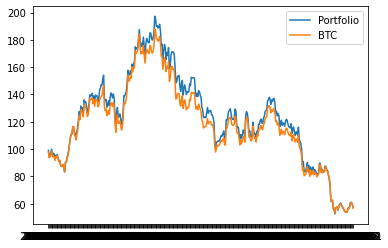

In [ ]:
plt.plot(portfolio['Date'],portfolio['Val_Portfolio'])
plt.plot(portfolio['Date'],portfolio['Val_BTC'])
plt.legend(["Portfolio", "BTC"])

In [ ]:
#Vol and drawdown
Vol_BTC=returns_from_prices(portfolio['Val_BTC']).std()*365**.5
Vol_Portfolio=returns_from_prices(portfolio['Val_Portfolio']).std()*365**.5

In [ ]:
Vol_Portfolio

0.6882182153599186

## Indice Theme

Get the liste of categorie

In [ ]:
def GetListCoin(cat="",mkcap=1000000000):
  cg = CoinGeckoAPI()
  listeBanCoin=['tether','usd-coin','binance-usd','terrausd','dai','compound-usd-coin','shiba-inu','dogecoin','cdai','true-usd','staked-ether']
  if cat=="":
    df=pd.DataFrame(cg.get_coins_markets(vs_currency='usd',per_page=50))
  else :
    df=pd.DataFrame(cg.get_coins_markets(vs_currency='usd',category=cat,per_page=50))
  df2 = df[["id","symbol","name",'current_price','market_cap','total_volume','circulating_supply','total_supply','ath','ath_change_percentage']]
  df2.drop(df2[df2["market_cap"]<=mkcap ].index,inplace=True)
  df2.drop(df2[df2["circulating_supply"]==0 ].index,inplace=True)
  df2.dropna(inplace=True)
  liste=list(df2['id'])
  for i in listeBanCoin :
    if i in liste :
      df2.drop(df2[df2["id"]==i].index,inplace=True)
  liste=list(df2['id'])
  return liste


In [ ]:
df=GetListCoin("layer-1",1000000000)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
def GetMkCap(dico,nameIndice):
  l=[]
  for i in nameIndice :
    l.append(dico[i][2])
  MarketCap =pd.DataFrame(l).transpose()
  MarketCap.columns=nameIndice
  MarketCap.index=pd.to_datetime(dico[nameIndice[0]][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')
  MarketCap.drop(MarketCap.tail(1).index,inplace=True)
  return MarketCap

In [ ]:
def GetPriceAndReturn(dico,nameIndice):
  l=[]
  for i in nameIndice :
    l.append(dico[i][1])
  Price =pd.DataFrame(l).transpose()
  Price.columns=nameIndice
  daily_return = returns_from_prices(Price)
  daily_return.index=pd.to_datetime(dico[nameIndice[0]][0][1:], format = '%m/%d/%Y').strftime('%Y-%m-%d')
  Price.index=pd.to_datetime(dico[nameIndice[0]][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')
  return Price, daily_return

In [ ]:
def GetDataMkCap(df):
  dico = {}
  liste2=[]
  c=0
  time.sleep(25)
  for i in df:
    l=cg.get_coin_market_chart_by_id(i,vs_currency='USD',days=500)
    if c==48 :
      time.sleep(60)
    if len(l['prices'])==501 and l['market_caps'][0][1]!=0 :
      liste2.append(i)
      b=[]
      b.append([el[0] for el in l['prices']])
      b[0]=[datetime.fromtimestamp(d/1000) for d in b[0]]
      b.append([el[1] for el in l['prices']])
      b.append([el[1] for el in l['market_caps']])   
      dico[i]=b
    c=c+1
  price, daily_return = GetPriceAndReturn(dico,liste2)
  marketcap = GetMkCap(dico,liste2)
  return price, daily_return, marketcap

In [ ]:
df=GetListCoin("decentralized-finance-defi",100000000)
cg = CoinGeckoAPI()
price, daily_return, marketcap = GetDataMkCap(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


HTTPError: ignored

In [ ]:
price.columns

In [ ]:
cg.get_coin_market_chart_by_id("",vs_currency='USD',days=500)

In [ ]:
def SharpeRatio(df,df3,period=250):
  l=[]
  df2=df.head(249)
  df3=df3.head(250)
  for i in df.columns :
    vol=df2[i].std()*365**.5
    rd=(df3[i][-1]-df3[i][0])/df3[i][0]
    sharpe=rd/vol
    l.append([vol,rd,sharpe])
  return pd.DataFrame(l,columns=["Vol","Rd","Sharpe"],index=df2.columns)

In [ ]:
def SelectIndiceCovSharpe(daily_return,price,nb=10):
  l=SharpeRatio(daily_return,price)
  l.sort_values(by=["Sharpe"],ascending=False,inplace=True)
  cov = sample_cov(price.head(250),frequency=365)
  nameIndice2 = [l.index[0]]
  [nameIndice2.append(i) for i in cov.sort_values(by=l.index[0]).index[:nb-1]]
  nameIndice1=l.index[:nb].tolist()
  l.sort_values(by=["Vol"],ascending=True,inplace=True)
  nameIndice3=l.index[:nb].tolist()
  nameIndice4 = [l.index[0]]
  [nameIndice4.append(i) for i in cov.sort_values(by=l.index[0]).index[:nb-1]]
  l.sort_values(by=["Rd"],ascending=False,inplace=True)
  nameIndice5=l.index[:nb].tolist()
  nameIndice6 = [l.index[0]]
  [nameIndice6.append(i) for i in cov.sort_values(by=l.index[0]).index[:nb-1]]
  return [nameIndice1, nameIndice2, nameIndice3, nameIndice4, nameIndice5, nameIndice6]

In [ ]:
df=GetListCoin("smart-contract-platform",1000000000)
price, daily_return, marketcap = GetDataMkCap(df)
l = SelectIndiceCovSharpe(daily_return,price)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


KeyboardInterrupt: ignored

In [ ]:
def GetWeight(MarketCap, nameIndice, period=250):
  date=(datetime.today()-timedelta(499)).strftime('%Y-%m-%d')
  fin=0
  w_portfolio=[]
  MarketCap=MarketCap[nameIndice]
  while fin == 0 :
    weight=[]
    sum=np.sum(MarketCap[MarketCap.index==date].values[0])
    for i in range(len(nameIndice)):
      weight.append(MarketCap[MarketCap.index==date].values[0][i]/sum)
    w_portfolio.append(weight)
    date=(datetime.strptime(date,'%Y-%m-%d') + relativedelta(months=1)).strftime('%Y-%m-%d')
    date=date[:8]+'01'
    if date > (datetime.today()-timedelta(period)).strftime('%Y-%m-%d'):
      fin = 1
  return w_portfolio

In [ ]:
def GetWeight2(MarketCap, nameIndice, period=250):
  date=(datetime.today()-timedelta(period)).strftime('%Y-%m-%d')
  fin=0
  w_portfolio=[]
  MarketCap=MarketCap[nameIndice]
  while fin == 0 :
    weight=[]
    sum=np.sum(MarketCap[MarketCap.index==date].values[0])
    for i in range(len(nameIndice)):
      weight.append(MarketCap[MarketCap.index==date].values[0][i]/sum)
    w_portfolio.append(weight)
    date=(datetime.strptime(date,'%Y-%m-%d') + relativedelta(months=1)).strftime('%Y-%m-%d')
    date=date[:8]+'01'
    if date >= (datetime.today()).strftime('%Y-%m-%d'):
      fin = 1
  return w_portfolio

In [ ]:
def GetAllWeight(MarketCap,liste,period=250):
  l=[]
  for i in liste:
    l.append(GetWeight(MarketCap,i))
  return l

In [ ]:
df=GetListCoin("smart-contract-platform",1000000000)
cg = CoinGeckoAPI()
price, daily_return, marketcap = GetDataMkCap(df)
listeName = SelectIndiceCovSharpe(daily_return,price)
listeWeight = GetAllWeight(marketcap,listeName)

In [ ]:
len(listeWeight[0])

In [ ]:
def PortfolioValue2(w_portfolio,daily_return,nameIndice,period=250):
  daily_return2=daily_return[nameIndice]
  val_port=list(np.array(w_portfolio[0])*100)
  val_btc=100
  val=[]
  date=(datetime.today()-timedelta(499))
  rdt=daily_return2.iloc[:249,:]
  btc=daily_price_historical('BTC','USD')
  btc=btc[["close","timestamp"]]
  btc.columns=["close",'Date']
  btc.set_index(btc['Date'],inplace=True)
  btc=returns_from_prices(btc['close'])
  btc=btc[btc.index>=date]
  btc=btc.head(249)
  for i in range(len(rdt)):
    mth=(datetime.strptime(rdt.index[i],'%Y-%m-%d').year - date.year) * 12 + (datetime.strptime(rdt.index[i],'%Y-%m-%d').month - date.month)
    val_port=list(np.array(w_portfolio[mth])*np.sum(val_port))*(1+rdt.values[i])
    val_btc=(1+btc[i])*val_btc
    val.append([rdt.index[i],np.sum(val_port),val_btc])
  portfolio=pd.DataFrame(val,columns=['Date','Val_Portfolio','Val_BTC'])
  return portfolio

In [ ]:
def PortfolioValue(w_portfolio,daily_return,nameIndice,period=250):
  daily_return2=daily_return[nameIndice]
  val_port=list(np.array(w_portfolio[0])*100)
  val_btc=100
  val=[]
  date=(datetime.today()-timedelta(period))
  rdt=daily_return2[daily_return2.index>=str(date)]
  btc=daily_price_historical('BTC','USD')
  btc=btc[["close","timestamp"]]
  btc.columns=["close",'Date']
  btc.set_index(btc['Date'],inplace=True)
  btc=returns_from_prices(btc['close'])
  btc=btc[btc.index>=str(date)]
  print(len(btc))
  print(len(rdt))
  print(btc.head(1))
  print(rdt.head(1))
  #Probleme long : merge, verif longueur 
  for i in range(len(rdt)):
    mth=(datetime.strptime(rdt.index[i],'%Y-%m-%d').year - date.year) * 12 + (datetime.strptime(rdt.index[i],'%Y-%m-%d').month - date.month)
    val_port=list(np.array(w_portfolio[mth])*np.sum(val_port))*(1+rdt.values[i])
    val_btc=(1+btc[i])*val_btc
    val.append([rdt.index[i],np.sum(val_port),val_btc])
  portfolio=pd.DataFrame(val,columns=['Date','Val_Portfolio','Val_BTC'])
  return portfolio

In [ ]:
def GetAllPortfolioValue(listeWeight,daily_return,listeName,period=250):
  l=[]
  for i in range(len(listeWeight)) :
    l.append(PortfolioValue(listeWeight[i],daily_return,listeName[i]))
  return l

In [ ]:
def GetAllPortfolioValue2(listeWeight,daily_return,listeName,period=250):
  l=[]
  for i in range(len(listeWeight)) :
    l.append(PortfolioValue2(listeWeight[i],daily_return,listeName[i]))
  return l

In [ ]:
def drawdown(portfolio: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    return_series1=returns_from_prices(portfolio['Val_Portfolio'])
    wealth_index1 = 1000*(1+return_series1).cumprod()
    previous_peaks1 = wealth_index1.cummax()
    drawdowns1 = (wealth_index1 - previous_peaks1)/previous_peaks1
    return_series2=returns_from_prices(portfolio['Val_BTC'])
    wealth_index2 = 1000*(1+return_series2).cumprod()
    previous_peaks2 = wealth_index2.cummax()
    drawdowns2 = (wealth_index2 - previous_peaks2)/previous_peaks2
    Vol_BTC=return_series2.std()*365**.5
    Vol_Portfolio=return_series1.std()*365**.5
    rd_BTC=(portfolio['Val_BTC'][len(portfolio)-1]-100)/100
    rd_Portfolio=(portfolio['Val_Portfolio'][len(portfolio)-1]-100)/100
    Sharpe_BTC = rd_BTC/Vol_BTC
    Sharpe_Portfolio = rd_Portfolio/Vol_Portfolio
    return pd.DataFrame({"Wealth Portfolio": wealth_index1, 
                         "Previous Peak Portfolio": previous_peaks1, 
                         "Drawdown Portfolio": drawdowns1,
                         "Wealth BTC": wealth_index2, 
                         "Previous Peak BTC": previous_peaks2, 
                         "Drawdown BTC": drawdowns2}),pd.DataFrame({'Vol':[Vol_BTC,Vol_Portfolio],'Rd':[rd_BTC,rd_Portfolio],'Sharpe':[Sharpe_BTC,Sharpe_Portfolio]},index=['BTC','Portfolio'])


In [ ]:
def GetAllDrawdown(listePortfolioValue):
  draw={}
  metric={}
  for i in range(len(listePortfolioValue)):
    draw[i], metric[i] = drawdown(listePortfolioValue[i])
  return draw, metric

In [ ]:
df=GetListCoin("smart-contract-platform",1000000000)
price, daily_return, marketcap = GetDataMkCap(df)
listeName = SelectIndiceCovSharpe(daily_return,price,5)
listeWeight = GetAllWeight(marketcap,listeName)
listePortfolioValue = GetAllPortfolioValue2(listeWeight,daily_return,listeName)
draw, metric = GetAllDrawdown(listePortfolioValue)

In [ ]:
def GetIndiceStatique(cat,nb):
  df=GetListCoin(cat,1000000000)
  price, daily_return, marketcap = GetDataMkCap(df)
  listeName,listeWeight,listePortfolioValue,draw,metric=[],[],[],[],[]
  for i in nb:
    name=SelectIndiceCovSharpe(daily_return,price,i)
    print(name)
    listeName.append(name)
    weight=GetAllWeight(marketcap,name)
    listeWeight.append(weight)
    portfolio=GetAllPortfolioValue2(weight,daily_return,name)
    listePortfolioValue.append(portfolio)
    d, m = GetAllDrawdown(portfolio)
    draw.append(d)
    metric.append(m)
  return listeName, listeWeight, listePortfolioValue, draw, metric, daily_return, marketcap

In [ ]:
def SelectionIndiceBySharpe(listeName,listeWeight,listePortfolioValue,draw,metric):
  l=[]
  for i in range(len(listeName)):
    metric_best=metric[i][0].iloc[1,2]
    compteur=0
    for j in range(1,len(listeName[i])):
      if metric[i][j].iloc[1,2] > metric_best:
        compteur=j
    l.append([listeName[i][compteur],listeWeight[i][compteur],listePortfolioValue[i][compteur],draw[i][compteur],metric[i][compteur]])
  return l

In [ ]:
def SelectionIndiceByDrawdown(listeName,listeWeight,listePortfolioValue,draw,metric):
  l=[]
  for i in range(len(listeName)):
    metric_best=draw[i][0].iloc[len(draw[i][0])-1,2]
    compteur=0
    for j in range(1,len(listeName[i])):
      if draw[i][j].iloc[len(draw[i][j])-1,2] > metric_best:
        compteur=j
    l.append([listeName[i][compteur],listeWeight[i][compteur],listePortfolioValue[i][compteur],draw[i][compteur],metric[i][compteur]])
  return l

In [ ]:
def SelectIndiceStatique():
  liste=["layer-1","exchange-based-tokens","decentralized-finance-defi","non-fungible-tokens-nft","protocol","smart-contract-platform"]
  l=[]
  for i in liste :
    print(i)
    if i in ["layer-1","decentralized-finance-defi","smart-contract-platform"]:
      listeName, listeWeight, listePortfolioValue, draw, metric, daily_return, marketcap = GetIndiceStatique(i,[5,10,15])
      best_by_Drawdown = SelectionIndiceByDrawdown(listeName,listeWeight,listePortfolioValue,draw,metric)
      best_by_Sharpe = SelectionIndiceBySharpe(listeName,listeWeight,listePortfolioValue,draw,metric)
      time.sleep(45)
    elif i in ["non-fungible-tokens-nft","protocol"] :
      listeName, listeWeight, listePortfolioValue, draw, metric, daily_return, marketcap = GetIndiceStatique(i,[5])
      best_by_Drawdown = SelectionIndiceByDrawdown(listeName,listeWeight,listePortfolioValue,draw,metric)
      best_by_Sharpe = SelectionIndiceBySharpe(listeName,listeWeight,listePortfolioValue,draw,metric)
    else : 
      listeName, listeWeight, listePortfolioValue, draw, metric, daily_return, marketcap = GetIndiceStatique(i,[5,10])
      best_by_Drawdown = SelectionIndiceByDrawdown(listeName,listeWeight,listePortfolioValue,draw,metric)
      best_by_Sharpe = SelectionIndiceBySharpe(listeName,listeWeight,listePortfolioValue,draw,metric)
    l.append([best_by_Drawdown,best_by_Sharpe, daily_return, marketcap])    
  return l

In [ ]:
cg = CoinGeckoAPI()
l=SelectIndiceStatique()

layer-1


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[['axie-infinity', 'solana', 'the-sandbox', 'matic-network', 'decentraland'], ['axie-infinity', 'leo-token', 'frax', 'wrapped-bitcoin', 'bitcoin'], ['frax', 'wrapped-bitcoin', 'bitcoin', 'leo-token', 'ethereum'], ['frax', 'leo-token', 'frax', 'wrapped-bitcoin', 'flow'], ['axie-infinity', 'solana', 'the-sandbox', 'decentraland', 'matic-network'], ['axie-infinity', 'leo-token', 'frax', 'wrapped-bitcoin', 'bitcoin']]
[['axie-infinity', 'solana', 'the-sandbox', 'matic-network', 'decentraland', 'helium', 'ethereum-classic', 'ethereum', 'vechain', 'hedera-hashgraph'], ['axie-infinity', 'leo-token', 'frax', 'wrapped-bitcoin', 'bitcoin', 'cardano', 'solana', 'helium', 'ethereum', 'okb'], ['frax', 'wrapped-bitcoin', 'bitcoin', 'leo-token', 'ethereum', 'crypto-com-chain', 'litecoin', 'ftx-token', 'cardano', 'stellar'], ['frax', 'leo-token', 'frax', 'wrapped-bitcoin', 'flow', 'bitcoin', 'filecoin', 'ethereum-classic', 'theta-token', 'crypto-com-chain'], ['axie-infinity', 'solana', 'the-sandbox', 

In [ ]:
liste=['axie-infinity','solana']
price, daily_return, marketcap = GetDataMkCap(liste)
price.drop(price.tail(1).index,inplace=True)
daily_return.drop(daily_return.tail(1).index,inplace=True)

In [ ]:
wei = GetWeight2(marketcap,liste)
portfolio=PortfolioValue(wei,daily_return,liste)

In [ ]:
liste=["layer-1","exchange-based-tokens","decentralized-finance-defi","non-fungible-tokens-nft","protocol","smart-contract-platform"]

In [ ]:
print(l[5])

[[[['solana', 'matic-network', 'ethereum-classic', 'ethereum', 'vechain'], [[0.020680985635720055, 0.005360236095641476, 0.007167634518254779, 0.9521266170846431, 0.014664526665740639], [0.02028124764232906, 0.006510233316271811, 0.0070287313204903685, 0.9510669951714558, 0.01511279254945294], [0.022193732605093677, 0.007660727552933173, 0.006994733885874203, 0.9388657856659863, 0.024285020290112636], [0.03269194946237554, 0.014036085459115893, 0.012978832057890894, 0.9031418777777249, 0.03715125524289268], [0.025313829629289228, 0.0336633111465253, 0.02533300983723496, 0.8922708753054029, 0.023418974081547545], [0.03300344139912609, 0.024748794860532844, 0.025162393930806076, 0.8970487648623514, 0.020036604947183637], [0.03019739067541295, 0.02137507154872206, 0.02040361388911687, 0.9101335609028788, 0.017890362983869423], [0.06867778445758656, 0.019048421577979438, 0.018024155277559663, 0.8763892629644614, 0.017860375722412936], [0.1007586806780972, 0.01804988065296685, 0.01467037199

In [ ]:
for i in range(len(l)):
  print(l[i])


[[[['axie-infinity', 'solana', 'the-sandbox', 'matic-network', 'decentraland'], [[0.01603686703061358, 0.706165466952161, 0.031090647956787943, 0.1830286859691395, 0.06367833209129795], [0.015130094763384939, 0.6771545535762353, 0.02869967642441044, 0.21736503654520317, 0.06165063869076619], [0.03410130063730014, 0.5654424723060877, 0.05976166352275738, 0.1951767557206547, 0.1455178078131999], [0.028897778008279154, 0.5931497483330007, 0.022299761210726056, 0.2546651605232879, 0.10098755192470618], [0.012212621231171176, 0.39778839556143225, 0.010438511748208666, 0.5289944163473289, 0.05056605511185889], [0.017204335949437176, 0.5323950128963125, 0.009355918071410705, 0.3992351827676514, 0.04180955031518813], [0.11492390035989543, 0.4781345805995227, 0.02188830268099814, 0.3384451650173332, 0.046608051342250524], [0.08997041931200593, 0.6770676509369687, 0.018273205596015692, 0.18779100336040208, 0.02689772079460761], [0.07817717841548431, 0.7586656030241627, 0.010741414855542473, 0.13

In [ ]:
#Create indice from the last 250 day after the selection
dico={}
listecat=["layer-1","exchange-based-tokens","decentralized-finance-defi","non-fungible-tokens-nft","protocol","smart-contract-platform"]
listeselect=["Drawdown","Sharpe"]
for i in range(len(l)):
  for j in range(2):
    for h in range(len(l[i][j])):
      weight=GetWeight2(l[i][3], l[i][j][h][0], period=240)
      portfolio=PortfolioValue(weight,l[i][2],l[i][j][h][0])
      draw, metric= drawdown(portfolio)
      dico[listecat[i]+" "+listeselect[j]+" "+str(len(l[i][j][h][0]))+" assets"]=[l[i][j][h][0],weight,portfolio, draw, metric]


250
251
Date
2021-11-04   -0.023541
Name: close, dtype: float64
            axie-infinity   solana  the-sandbox  matic-network  decentraland
2021-11-04       0.008199  0.09695     0.060466       0.051533     -0.089396


IndexError: ignored

In [ ]:
l

[[[[['axie-infinity',
     'solana',
     'the-sandbox',
     'matic-network',
     'decentraland'],
    [[0.01603686703061358,
      0.706165466952161,
      0.031090647956787943,
      0.1830286859691395,
      0.06367833209129795],
     [0.015130094763384939,
      0.6771545535762353,
      0.02869967642441044,
      0.21736503654520317,
      0.06165063869076619],
     [0.03410130063730014,
      0.5654424723060877,
      0.05976166352275738,
      0.1951767557206547,
      0.1455178078131999],
     [0.028897778008279154,
      0.5931497483330007,
      0.022299761210726056,
      0.2546651605232879,
      0.10098755192470618],
     [0.012212621231171176,
      0.39778839556143225,
      0.010438511748208666,
      0.5289944163473289,
      0.05056605511185889],
     [0.017204335949437176,
      0.5323950128963125,
      0.009355918071410705,
      0.3992351827676514,
      0.04180955031518813],
     [0.11492390035989543,
      0.4781345805995227,
      0.02188830268099814,
      0

In [ ]:
 !pip install xlsxwriter 

In [ ]:
import xlsxwriter

In [ ]:
#Add Drawdown in the dataframe metric
for name, dict_ in dico.items():
  dict_[4]['Drawdown']=pd.DataFrame(dict_[3][["Drawdown Portfolio","Drawdown BTC"]].tail(1).values.transpose(),index=['Portfolio','BTC'])

In [ ]:
#Get in list all the name, metric, value, compo and asset by asset number in the index
name5, name10, name15=[],[],[]
metric5, metric10, metric15=[],[],[]
value5, value10, value15 = [],[],[]
compo5, compo10, compo15=[],[],[]
asset5, asset10, asset15=[],[],[]

for name, dict_ in dico.items():
  if name[-9:] == '15 assets':
    value15.append(dict_[2])
    metric15.append(dict_[4])
    name15.append(name[:-9])
    compo15.append(dict_[1][-1])
    asset15.append(dict_[0])
  elif name[-9:] == '10 assets':
    value10.append(dict_[2])
    metric10.append(dict_[4])
    name10.append(name[:-9])
    compo10.append(dict_[1][-1])
    asset10.append(dict_[0])
  else:
    compo5.append(dict_[1][-1])
    value5.append(dict_[2])
    metric5.append(dict_[4])
    name5.append(name[:-9])
    asset5.append(dict_[0])

In [ ]:
dict

[]

In [ ]:
#Transform into DataFrame for to_excel for 5 assets Index
value=[]
metric=[]
compo=[]
asset=[]
for i in range(len(name5)):
  value.append(value5[i]["Val_Portfolio"].tolist())
  metric.append(metric5[i][metric5[i].index=='Portfolio'].values[0].tolist())
  compo.append(compo5[i])
  asset.append(asset5[i])
value.append(value5[0]["Val_BTC"].tolist())
metric.append(metric5[i][metric5[i].index=='BTC'].values[0].tolist())
df_value5=pd.DataFrame(value).transpose()
df_value5.columns=name5+['BTC']
df_metric5=pd.DataFrame(metric, index=name5+['BTC'], columns=['Volatility','Return','Sharpe Ratio','Drawdown'])
df_compo5=pd.DataFrame(compo, index=name5)
df_asset5=pd.DataFrame(asset, index=name5)

In [ ]:
#Transform into DataFrame for to_excel for 10 assets Index
value=[]
metric=[]
compo=[]
asset=[]
for i in range(len(name10)):
  value.append(value10[i]["Val_Portfolio"].tolist())
  metric.append(metric10[i][metric10[i].index=='Portfolio'].values[0].tolist())
  compo.append(compo10[i])
  asset.append(asset10[i])
value.append(value10[0]["Val_BTC"].tolist())
metric.append(metric10[i][metric10[i].index=='BTC'].values[0].tolist())
df_value10=pd.DataFrame(value).transpose()
df_value10.columns=name10+['BTC']
df_metric10=pd.DataFrame(metric, index=name10+['BTC'], columns=['Volatility','Return','Sharpe Ratio','Drawdown'])
df_compo10=pd.DataFrame(compo, index=name10)
df_asset10=pd.DataFrame(asset, index=name10)

In [ ]:
#Transform into DataFrame for to_excel for 15 assets Index
value=[]
metric=[]
compo=[]
asset=[]
for i in range(len(name15)):
  value.append(value15[i]["Val_Portfolio"].tolist())
  metric.append(metric15[i][metric15[i].index=='Portfolio'].values[0].tolist())
  compo.append(compo15[i])
  asset.append(asset15[i])
value.append(value15[0]["Val_BTC"].tolist())
metric.append(metric15[i][metric15[i].index=='BTC'].values[0].tolist())
df_value15=pd.DataFrame(value).transpose()
df_value15.columns=name15+['BTC']
df_metric15=pd.DataFrame(metric, index=name15+['BTC'], columns=['Volatility','Return','Sharpe Ratio','Drawdown'])
df_compo15=pd.DataFrame(compo, index=name15)
df_asset15=pd.DataFrame(asset, index=name15)

In [ ]:
#Save into 3 different excel : 1 by number asset
Asset_5=[df_value5,df_metric5,df_compo5,df_asset5]
Asset_15=[df_value15,df_metric15,df_compo15,df_asset15]
Asset_10=[df_value10,df_metric10,df_compo10,df_asset10]
liste=[Asset_5,Asset_10,Asset_15]
c=0
for i in liste:
  if c==0 :
    workbook = xlsxwriter.Workbook('Index_5.xlsx')
    name='Index_5.xlsx'
  elif c==1:
    workbook = xlsxwriter.Workbook('Index_10.xlsx')
    name='Index_10.xlsx'
  else:
    workbook = xlsxwriter.Workbook('Index_15.xlsx')
    name='Index_15.xlsx'
  worksheet = workbook.add_worksheet('Value')
  worksheet = workbook.add_worksheet('Metric')
  worksheet = workbook.add_worksheet('Compo')
  worksheet = workbook.add_worksheet('Asset')
  workbook.close()
  with pd.ExcelWriter(name) as writer:
    i[1].to_excel(writer,sheet_name='Metric')
    i[0].to_excel(writer,sheet_name='Value')
    i[2].to_excel(writer,sheet_name='Compo')
    i[3].to_excel(writer,sheet_name='Asset')
  c=c+1

In [ ]:
for name,dict_ in dico.items():
  
  print(dict_[0])
  print(name)
  print(dict_[3][["Drawdown Portfolio","Drawdown BTC"]].tail(1))
  print(dict_[4])
  print("-------------------------------------------")

In [ ]:
for name,dict_ in dico.items():
  print(dict_[0])
  dict_[2].set_index(dict_[2]['Date'],inplace=True)
  plt.plot(dict_[2]['Val_Portfolio'],c='blue')
  plt.plot(dict_[2]['Val_BTC'],c='green')
  plt.title(name)
  plt.show()

In [ ]:
pr

## Indice BTC + ETH avec market cap > 2 000 000 000

In [ ]:
cg = CoinGeckoAPI()
#Top 100 by marketcap
df=pd.DataFrame(cg.get_coins_markets(vs_currency='usd',price_change_percentage='7d,30d,1y',per_page=100))
df2 = df[["id","symbol","name",'current_price','market_cap','total_volume','price_change_percentage_24h','circulating_supply','total_supply','ath','ath_change_percentage','price_change_percentage_7d_in_currency','price_change_percentage_30d_in_currency','price_change_percentage_1y_in_currency']]
df2["symbol"]=df2["symbol"].str.upper()
df2.drop(df2[df2["market_cap"]<=2000000000 ].index,inplace=True)
df2.drop(df2[df2["circulating_supply"]==0 ].index,inplace=True)

In [ ]:
listeBanCoin=['tether','usd-coin','binance-usd','terrausd','dai','compound-usd-coin','shiba-inu','dogecoin','cdai','true-usd','staked-ether']
liste=list(df2["id"])
for i in listeBanCoin:
  if i in liste :
    liste.remove(i)
dico = {}
c=0
for i in liste:
  l=cg.get_coin_market_chart_by_id(i,vs_currency='USD',days=500)
  if c==48 :
    time.sleep(45)
  if len(l['prices'])==501 and l['market_caps'][0][1]!=0 :
    b=[]
    b.append([el[0] for el in l['prices']])
    b[0]=[datetime.fromtimestamp(d/1000) for d in b[0]]
    b.append([el[1] for el in l['prices']])
    b.append([el[1] for el in l['market_caps']])   
    dico[i]=b
  c=c+1

In [ ]:
l=[]
name=[]
for i in dico :
  l.append(dico[i][1][:250])
  name.append(i)
df=pd.DataFrame(l).transpose()
df.columns=name

In [ ]:
#Create the cov matrix and take the 8 assets who have the less covariance against btc
cov = sample_cov(df,frequency=365)
nameIndice1 = ['bitcoin','ethereum']
[nameIndice1.append(i) for i in cov.sort_values(by='bitcoin').index[:8]]
#Get the MarketCap
l=[]
for i in nameIndice1 :
  l.append(dico[i][2])
  name.append(i)
MarketCap =pd.DataFrame(l).transpose()
MarketCap.columns=nameIndice1
MarketCap.index=pd.to_datetime(dico['ethereum'][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')
#Get the Price of each asset chosen and them daily return
l=[]
for i in nameIndice1 :
  l.append(dico[i][1])
  name.append(i)
Price =pd.DataFrame(l).transpose()
Price.columns=nameIndice1
daily_return = returns_from_prices(Price)
daily_return.index=pd.to_datetime(dico['ethereum'][0][1:], format = '%m/%d/%Y').strftime('%Y-%m-%d')
Price.index=pd.to_datetime(dico['ethereum'][0], format = '%m/%d/%Y').strftime('%Y-%m-%d')

In [ ]:
#Calculate the weight
fin = 0
date='2021-07-01'
w_portfolio=[]
while fin == 0 :
  weight=[]
  sum=np.sum(MarketCap[MarketCap.index==date].values[0])
  for i in range(10):
    weight.append(MarketCap[MarketCap.index==date].values[0][i]/sum)
  w_portfolio.append(weight)
  date=(datetime.strptime(date,'%Y-%m-%d') + relativedelta(months=1)).strftime('%Y-%m-%d')
  if date > datetime.today().strftime('%Y-%m-%d'):
    fin = 1

In [ ]:
MarketCap.head()

In [ ]:
#Portfolio value on time
val_port=list(np.array(w_portfolio[0])*100)
val_btc=100
val=[]
date=datetime.strptime('2021-07-01','%Y-%m-%d')
rdt=daily_return[daily_return.index>='2021-07-01']
for i in range(len(rdt)):
  mth=(datetime.strptime(rdt.index[i],'%Y-%m-%d').year - date.year) * 12 + (datetime.strptime(rdt.index[i],'%Y-%m-%d').month - date.month)
  val_port=list(np.array(w_portfolio[mth])*np.sum(val_port))*(1+rdt.values[i])
  val_btc=(1+rdt.values[i][0])*val_btc
  val.append([rdt.index[i],np.sum(val_port),val_btc])
portfolio=pd.DataFrame(val,columns=['Date','Val_Portfolio','Val_BTC'])

In [ ]:
portfolio

In [ ]:
plt.plot(portfolio['Date'],portfolio['Val_Portfolio'])
plt.plot(portfolio['Date'],portfolio['Val_BTC'])
plt.legend(["Portfolio", "BTC"])

In [ ]:
#Vol and drawdown
Vol_BTC=returns_from_prices(portfolio['Val_BTC']).std()*365**.5
Vol_Portfolio=returns_from_prices(portfolio['Val_Portfolio']).std()*365**.5

In [ ]:
Vol_BTC

In [ ]:
Vol_Portfolio

In [ ]:
drawdown(returns_from_prices(portfolio['Val_Portfolio']))

In [ ]:
drawdown(returns_from_prices(portfolio['Val_BTC']))

# Historical Return And Matrix Cov

## Historical Returns

In [ ]:
mu={}

#Calculate annualised mean (daily) historical return from input (daily) asset prices
mu[1] = mean_historical_return(df2,frequency=365)

#Calculate the exponentially-weighted mean of (daily) historical returns, giving higher weight to more recent data
##The time-span for the EMA, defaults to 500-day EMA
mu[2] = ema_historical_return(df2,frequency=365,span=500)
mu[3] = ema_historical_return(df2,frequency=365,span=200)

#Return estimate using the Capital Asset Pricing Model
mu[4] = capm_return(df2,frequency=365)

#Calculate the daily return for plot the portfolio performance
daily_return = returns_from_prices(df2)

## Risk Models (Covariance Matrix)

In [ ]:
cov={}

#Calculate the annualised sample covariance matrix of (daily) asset returns
cov[1] = sample_cov(df2,frequency=365)

#Estimate the semicovariance matrix, i.e the covariance given that the returns are less than the benchmark
cov[2] = semicovariance(df2,frequency=365)

#Estimate the semicovariance matrix, i.e the covariance given that the returns are less than the benchmark
cov[3] = exp_cov(df2,frequency=365, span=180)
cov[4] = exp_cov(df2,frequency=365, span=90)
cov[5] = exp_cov(df2,frequency=365, span=30)

#With Shrinkage
##Ledoit_Wolf permit to have the optimal value of shrinkage
cov[6] = CovarianceShrinkage(df2,frequency=365).ledoit_wolf(shrinkage_target='constant_variance')
cov[7] = CovarianceShrinkage(df2,frequency=365).ledoit_wolf(shrinkage_target='single_factor')
cov[8] = CovarianceShrinkage(df2,frequency=365).ledoit_wolf(shrinkage_target='constant_correlation')

##Oracle approximating shrinkage (OAS), invented by Chen et al. (2010) [5],
##which has a lower mean-squared error than Ledoit-Wolf shrinkage when samples are Gaussian or near-Gaussian
cov[9]=CovarianceShrinkage(df2,frequency=365).oracle_approximating()

#Check if a covariance matrix is positive semidefinite, and if not, fix it with the chosen method
cov2={}
for i in cov:
  cov2[i]=fix_nonpositive_semidefinite(cov[i])

# Portfolio

## Only Long

In [ ]:
ef = EfficientFrontier(mu[1], cov[1])
ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BTC', 0.0), ('ETH', 0.0), ('USDT', 0.0), ('BNB', 0.0), ('USDC', 0.0), ('XRP', 0.0), ('LUNA', 0.09937), ('SOL', 0.0), ('ADA', 0.0), ('AVAX', 0.0), ('DOT', 0.0), ('BUSD', 0.0), ('DOGE', 0.0), ('UST', 0.0), ('WBTC', 0.0), ('MATIC', 0.0), ('CRO', 0.0), ('ATOM', 0.0), ('DAI', 0.0), ('LTC', 0.0), ('NEAR', 0.0), ('LINK', 0.0), ('FTT', 0.0), ('TRX', 0.0), ('BCH', 0.0), ('ALGO', 0.0), ('LEO', 0.23003), ('OKB', 0.0), ('FTM', 0.0), ('XLM', 0.0), ('UNI', 0.0), ('HBAR', 0.0), ('ETC', 0.0), ('MANA', 0.0), ('AXS', 0.67059), ('SAND', 0.0), ('VET', 0.0), ('FIL', 0.0), ('EGLD', 0.0), ('XMR', 0.0), ('THETA', 0.0), ('KLAY', 0.0), ('XTZ', 0.0)])


In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 2258.6%
Annual volatility: 150.7%
Sharpe Ratio: 14.97


(22.585962049207566, 1.5074887743006222, 14.969240523649486)

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BTC', 0.0), ('ETH', 0.0), ('USDT', 0.0), ('BNB', 0.0), ('USDC', 0.0), ('XRP', 0.0), ('LUNA', 0.18556), ('SOL', 0.0), ('ADA', 0.0), ('AVAX', 0.0), ('DOT', 0.0), ('BUSD', 0.0), ('DOGE', 0.0), ('UST', 0.0), ('WBTC', 0.0), ('MATIC', 0.0), ('CRO', 0.0), ('ATOM', 0.0), ('DAI', 0.0), ('LTC', 0.0), ('NEAR', 0.0), ('LINK', 0.0), ('FTT', 0.0), ('TRX', 0.0), ('BCH', 0.0), ('ALGO', 0.0), ('LEO', 0.28942), ('OKB', 0.0), ('FTM', 0.0), ('XLM', 0.0), ('UNI', 0.0), ('HBAR', 0.0), ('ETC', 0.0), ('MANA', 0.0), ('AXS', 0.52503), ('SAND', 0.0), ('VET', 0.0), ('FIL', 0.0), ('EGLD', 0.0), ('XMR', 0.0), ('THETA', 0.0), ('KLAY', 0.0), ('XTZ', 0.0)])


In [ ]:
#Optimal Weight
ef.portfolio_performance(verbose=True)

Expected annual return: 651.7%
Annual volatility: 106.8%
Sharpe Ratio: 6.08


(6.516692590324102, 1.0683571889742232, 6.081011722832009)

In [ ]:
#Allow short position
ef2 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef2.max_sharpe()
cleaned_weights = ef2.clean_weights()
print(cleaned_weights)

OrderedDict([('BTC', -0.17882), ('ETH', 0.2536), ('USDT', 0.21239), ('BNB', 0.06877), ('USDC', 0.20603), ('XRP', 0.32272), ('LUNA', 0.7041), ('SOL', 0.54845), ('ADA', -0.12889), ('AVAX', -0.0662), ('DOT', -0.33721), ('BUSD', 0.28811), ('DOGE', 0.14564), ('UST', -0.10696), ('WBTC', -0.16253), ('MATIC', 0.51905), ('CRO', 0.32623), ('ATOM', 0.15638), ('DAI', 0.20113), ('LTC', -0.4383), ('NEAR', -0.09197), ('LINK', -0.08985), ('FTT', -0.10256), ('TRX', 0.27177), ('BCH', -0.60953), ('ALGO', -0.30221), ('LEO', 0.5158), ('OKB', -0.08096), ('FTM', 0.06615), ('XLM', -0.3965), ('UNI', -0.85552), ('HBAR', -0.0488), ('ETC', 0.67505), ('MANA', -0.00203), ('AXS', 1.0), ('SAND', 0.28842), ('VET', -0.22037), ('FIL', -0.12839), ('EGLD', -0.19668), ('XMR', -0.09313), ('THETA', -0.27182), ('KLAY', -0.47295), ('XTZ', -0.38761)])


In [ ]:
ef2.portfolio_performance(verbose=True)

Expected annual return: 2130.7%
Annual volatility: 219.5%
Sharpe Ratio: 9.70


(21.307437882799817, 2.195251194315809, 9.697039654468538)

In [ ]:
from pypfopt import objective_functions

In [ ]:
ef3 = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef3.add_objective(objective_functions.L2_reg)  # add a secondary objective
ef3.min_volatility()  # find the portfolio that minimises volatility and L2_reg
ef3.portfolio_performance(verbose=True)

AttributeError: ignored

In [ ]:
ef4 = EfficientFrontier(mu, S)
ef4.add_objective(objective_functions.L2_reg,gamma=1)  # add a secondary objective
ef4.min_volatility()  # find the portfolio that minimises volatility and L2_reg
ef4.portfolio_performance(verbose=True)

Expected annual return: 14.2%
Annual volatility: 20.0%
Sharpe Ratio: 0.61


(0.14239103255996813, 0.19976225579763718, 0.6126834725172131)

In [ ]:
ef4 = EfficientFrontier(mu, S)
ef4.add_objective(objective_functions.L2_reg,gamma=0.1)  # add a secondary objective
ef4.min_volatility()  # find the portfolio that minimises volatility and L2_reg
ef4.portfolio_performance(verbose=True)

Expected annual return: 3.8%
Annual volatility: 10.5%
Sharpe Ratio: 0.17


(0.038095753115432285, 0.10485120679198545, 0.17258507240009635)

In [ ]:
#Faire portefeuille en fonction des mois, mois par mois
#En forward
for i range()